In [1]:
%matplotlib inline
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string
import math

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from nltk import word_tokenize

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import requests
import pandas as pd
import xml.etree.ElementTree as ET
import warnings
import math
from tqdm import tqdm
from irsx.xmlrunner import XMLRunner
xml_runner = XMLRunner()
warnings.filterwarnings('ignore')
from collections import Counter

Using TensorFlow backend.


### Remapping US nonprofits

In [10]:
df_index=pd.concat([pd.read_csv('https://s3.amazonaws.com/irs-form-990/index_'+str(year)+'.csv') for year in range(2015, 2021)], ignore_index=True)
df_index['tax_year_end']=[str(s)[0:4] for s in df_index.TAX_PERIOD]
df_index.groupby('tax_year_end').count()

RETURN_ID  FILING_TYPE     EIN  TAX_PERIOD  SUB_DATE  \
tax_year_end                                                         
2012                428          428     428         428       428   
2013               4014         4014    4014        4014      4014   
2014             314450       314450  314450      314450    314450   
2015             408841       408841  408841      408841    408841   
2016             431843       431843  431843      431843    431843   
2017             452454       452454  452454      452454    452454   
2018             439161       439161  439161      439161    439161   
2019              57108        57108   57108       57108     57108   
2108                  1            1       1           1         1   

              TAXPAYER_NAME  RETURN_TYPE     DLN  OBJECT_ID  
tax_year_end                                                 
2012                    428          428     428        428  
2013                   4014         4014    4014       4014  
2014                 314450       314450  314450     314450  
2015                 408841       408841  408841     408841  
2016                 431843       431843  431843     431843  
2017                 452454       452454  452454     452454  
2018                 439161       439161  439161     439161  
2019                  57108        57108   57108      57108  
2108                      1            1       1          1

In [17]:
df_index_2018=df_index[df_index.tax_year_end=='2018']
df_index_2018.sample(5)

RETURN_ID FILING_TYPE        EIN  TAX_PERIOD               SUB_DATE  \
2011927   16993542       EFILE  814049787      201812   1/3/2020 12:56:23 PM   
1871946   16580380       EFILE  474675656      201812  8/19/2019 11:04:46 AM   
1640232   16785331       EFILE  481078400      201812  10/28/2019 6:16:28 AM   
2034274   17093729       EFILE  352069047      201812   1/31/2020 7:54:31 AM   
1893403   16573350       EFILE  820631249      201812   8/16/2019 8:33:52 AM   

                                           TAXPAYER_NAME RETURN_TYPE  \
2011927                          02 SCHOLARSHIP FUND INC       990EZ   
1871946                                      NAPUUOMALEI       990PF   
1640232          KANSAS ACADEMY OF FAMILY PHYSICIANS INC        990O   
2034274  FATHERS AND FAMILIES RESOURCERSEARCH CENTER INC         990   
1893403          SOUTHERN ARTISAN TRAINING INSTITUTE INC       990EZ   

                    DLN           OBJECT_ID tax_year_end  
2011927  93492317032699  201943179349203269         2018  
1871946  93491133039689  201931339349103968         2018  
1640232  93493248014019  201912489349301401         2018  
2034274  93493319133379  201923199349313337         2018  
1893403  93492130026819  201911309349202681         2018

#### Acquiring text data

In [18]:
import ipyparallel as ipp
c = ipp.Client()
print(c.ids)
dview = c[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


In [25]:
done_index_list=[]
dview.execute('import pandas as pd')
dview.execute('from time import sleep')
dview.execute('from irsx.xmlrunner import XMLRunner')
dview.execute('import os')
dview['xml_runner'] = XMLRunner()
dview['df_index'] = df_index
dview['df_index_text_acq'] = pd.DataFrame()
dview['done_index_list'] = list(set(done_index_list))
dview['counter']=0

In [27]:
@dview.parallel(block=True)
def func_text_acq(index):
    global df_index_2018, done_index_list, df_index_text_acq, counter
    
    ###### Define functions ######################################
    def func_irs990_text(obj_id):
        IRS990_result=xml_runner.run_sked(obj_id, 'IRS990').result

        ############## Check filing version.##############
        if IRS990_result!=None:
            IRS990_result=IRS990_result[0]
        else:
            return {'IRS990_p1_ActvtyOrMssnDsc': 'VERSION_NOT_SUPPORTED',
                    'IRS990_p3_MssnDsc': 'VERSION_NOT_SUPPORTED',
                    'IRS990_p3_DscS': 'VERSION_NOT_SUPPORTED',
                    'IRS990ScheduleO_ExplntnTxt': 'VERSION_NOT_SUPPORTED',
                   }
        ##################################################

        ###### IRS990_p1_ActvtyOrMssnDsc #################
        IRS990_p1_ActvtyOrMssnDsc=IRS990_result['schedule_parts']['part_i']['ActvtyOrMssnDsc']
        ##################################################

        ##### IRS990_p3_MssnDsc, IRS990_p3_DscS ##########
        IRS990_p3=IRS990_result['schedule_parts']['part_iii']
        IRS990_p3_MssnDsc='##'.join([IRS990_p3[key] for key in IRS990_p3.keys() if key=='MssnDsc'])
        IRS990_p3_DscS='##'.join([IRS990_p3[key] for key in IRS990_p3.keys() if (key=='Dsc' or '_Dsc' in key)])
        ##################################################

        ###### IRS990ScheduleO_ExplntnTxt #################
#         if 'InfInSkdOPrtIIIInd' in IRS990_p3.keys() and IRS990_p3['InfInSkdOPrtIIIInd']=='X' and 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
        if 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
            IRS990ScheduleO=xml_runner.run_sked(obj_id, 'IRS990ScheduleO').result[0]
            IRS990ScheduleO_ExplntnTxt='##'.join([s['ExplntnTxt'] for s in IRS990ScheduleO['groups']['SkdOSpplmntlInfrmtnDtl'] if 'III' in s['FrmAndLnRfrncDsc']])
        else:
            IRS990ScheduleO_ExplntnTxt=''
        ##################################################

        return {'IRS990_p1_ActvtyOrMssnDsc': IRS990_p1_ActvtyOrMssnDsc,
                'IRS990_p3_MssnDsc': IRS990_p3_MssnDsc,
                'IRS990_p3_DscS': IRS990_p3_DscS,
                'IRS990ScheduleO_ExplntnTxt': IRS990ScheduleO_ExplntnTxt,
               }
    
    def func_irs990ez_text(obj_id):
        IRS990EZ_result=xml_runner.run_sked(obj_id, 'IRS990EZ').result

        ############## Check filing version.##############
        if IRS990EZ_result!=None:
            IRS990EZ_result=IRS990EZ_result[0]
        else:
            return {'IRS990EZ_p3_PrmryExmptPrpsTxt': 'VERSION_NOT_SUPPORTED',
                    'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt': 'VERSION_NOT_SUPPORTED',
                    'IRS990ScheduleO_ExplntnTxt': 'VERSION_NOT_SUPPORTED',
                   }
        ########################################################

        ###### IRS990EZ_p3_PrmryExmptPrpsTxt #############
        if 'ez_part_iii' in IRS990EZ_result['schedule_parts'].keys():
            IRS990EZ_p3=IRS990EZ_result['schedule_parts']['ez_part_iii']
            IRS990EZ_p3_PrmryExmptPrpsTxt='##'.join([IRS990EZ_p3[key] for key in IRS990EZ_p3.keys() if key=='PrmryExmptPrpsTxt'])
        else:
            IRS990EZ_p3_PrmryExmptPrpsTxt=''
        ##################################################

        ####### IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt ######
        if 'EZPrgrmSrvcAccmplshmnt' in IRS990EZ_result['groups'].keys():
            IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt='##'.join([s['DscrptnPrgrmSrvcAccmTxt'] for s in IRS990EZ_result['groups']['EZPrgrmSrvcAccmplshmnt']])
        else:
            IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt=''
        ##################################################

        ###### IRS990ScheduleO_ExplntnTxt #################
#         if 'InfInSkdOPrtIIIInd' in IRS990EZ_p3.keys() and IRS990EZ_p3['InfInSkdOPrtIIIInd']=='X' and 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
        if 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
            IRS990ScheduleO=xml_runner.run_sked(obj_id, 'IRS990ScheduleO').result[0]
            IRS990ScheduleO_ExplntnTxt='##'.join([s['ExplntnTxt'] for s in IRS990ScheduleO['groups']['SkdOSpplmntlInfrmtnDtl'] if 'III' in s['FrmAndLnRfrncDsc']])
        else:
            IRS990ScheduleO_ExplntnTxt=''
        ##################################################

        return {'IRS990EZ_p3_PrmryExmptPrpsTxt': IRS990EZ_p3_PrmryExmptPrpsTxt,
                'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt': IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt,
                'IRS990ScheduleO_ExplntnTxt': IRS990ScheduleO_ExplntnTxt,
               }

    def func_irs990pf_text(obj_id):
        IRS990PF_result=xml_runner.run_sked(obj_id, 'IRS990PF').result

        ############## Check filing version.##############
        if IRS990PF_result!=None:
            IRS990PF_result=IRS990PF_result[0]
        else:
            return {'IRS990PF_p9a_DscrptnTxt': 'VERSION_NOT_SUPPORTED',
                    'IRS990PF_p16b_RltnshpSttmntTxt': 'VERSION_NOT_SUPPORTED',
                   }
        ########################################################

        ##### IRS990PF_p9a_DscrptnTxt ##########################
        if 'pf_part_ixa' in IRS990PF_result['schedule_parts'].keys():
            IRS990PF_p9a=IRS990PF_result['schedule_parts']['pf_part_ixa']
            IRS990PF_p9a_DscrptnTxt='##'.join([IRS990PF_p9a[key] for key in IRS990PF_p9a.keys() if 'Txt' in key])
        else:
            IRS990PF_p9a_DscrptnTxt=''
        ########################################################

        ##### IRS990PF_p16b_RltnshpSttmntTxt ###################
        if 'PFRlnOfActyTAccmOfExmptPrps' in IRS990PF_result['groups']:
            IRS990PF_p16b_RltnshpSttmntTxt='##'.join([s['RltnshpSttmntTxt'] for s in IRS990PF_result['groups']['PFRlnOfActyTAccmOfExmptPrps']])
        else:
            IRS990PF_p16b_RltnshpSttmntTxt=''
        ########################################################

        return {'IRS990PF_p9a_DscrptnTxt':IRS990PF_p9a_DscrptnTxt,
                'IRS990PF_p16b_RltnshpSttmntTxt':IRS990PF_p16b_RltnshpSttmntTxt,
               }
    ###### Define functions ######################################
    
    ###### Run main function ################################
    try:
        if index not in done_index_list:
            obj_id = df_index.loc[index, 'OBJECT_ID']
            return_type=df_index.loc[index, 'RETURN_TYPE']
            if return_type in ['990', '990O']:
                text_dict=func_irs990_text(obj_id)
                df_index.loc[index, 'IRS990_p1_ActvtyOrMssnDsc']=text_dict['IRS990_p1_ActvtyOrMssnDsc']
                df_index.loc[index, 'IRS990_p3_MssnDsc']=text_dict['IRS990_p3_MssnDsc']
                df_index.loc[index, 'IRS990_p3_DscS']=text_dict['IRS990_p3_DscS']
                df_index.loc[index, 'IRS990ScheduleO_ExplntnTxt']=text_dict['IRS990ScheduleO_ExplntnTxt']
            elif return_type in ['990EZ', '990EO']:
                text_dict=func_irs990ez_text(obj_id)
                df_index.loc[index, 'IRS990EZ_p3_PrmryExmptPrpsTxt']=text_dict['IRS990EZ_p3_PrmryExmptPrpsTxt']
                df_index.loc[index, 'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt']=text_dict['IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt']
                df_index.loc[index, 'IRS990ScheduleO_ExplntnTxt']=text_dict['IRS990ScheduleO_ExplntnTxt']
            elif return_type in ['990PF']:
                text_dict=func_irs990pf_text(obj_id)
                df_index.loc[index, 'IRS990PF_p9a_DscrptnTxt']=text_dict['IRS990PF_p9a_DscrptnTxt']
                df_index.loc[index, 'IRS990PF_p16b_RltnshpSttmntTxt']=text_dict['IRS990PF_p16b_RltnshpSttmntTxt']
            df_index_text_acq=pd.concat([df_index_text_acq, df_index.loc[[index]]], ignore_index=True)
            done_index_list+=[index]

            #### update progress file #####
            with open('../../output/pid_log/pid_'+str(os.getpid())+'.log', 'a') as log:
                log.write(str(index)+'\n')
            #### update progress file #####

    ###### Run main function ################################

            #### Sleep 2 seconds every 300 requests, adding ~2.5 hours in total #####
            counter+=1
            if counter%300==0:
                sleep(2)
            else:
                pass
            #### Sleep 2 seconds every 300 requests, adding ~2.5 hours in total #####
    except:
        pass

In [53]:
t=func_text_acq.map(df_index_2018.index)

In [54]:
done_index_list=list(dview.gather('done_index_list')) # Sync done_index_list.
len(set(done_index_list)), len(pd.concat(dview.gather('df_index_text_acq'), ignore_index=True))

(439160, 439160)

In [57]:
df_EIN_TXT_2018=pd.concat(dview.gather('df_index_text_acq'), ignore_index=True)
len(df_EIN_TXT_2018), len(df_index_2018)

(439160, 439161)

In [58]:
df_EIN_TXT_2018.to_pickle('../../dataset/intermediary/df_EIN_TXT_2018.pkl.bz2', compression='bz2')

#### Get BMF file and NTEE

In [6]:
# Read in data.
df_EIN_TXT_2018=pd.read_pickle('../../dataset/intermediary/df_EIN_TXT_2018.pkl.bz2', compression='bz2')
bmf_urls=['https://nccs-data.urban.org/data/bmf/2020/bmf.bm2004.csv',
          'https://nccs-data.urban.org/data/bmf/2019/bmf.bm1908.csv',
          'https://nccs-data.urban.org/data/bmf/2018/bmf.bm1812.csv'
         ]
df_bmf_18_20=pd.concat([pd.read_csv(url) for url in bmf_urls], ignore_index=True)

In [7]:
df_bmf_18_20_dropdup=df_bmf_18_20.loc[df_bmf_18_20.EIN.drop_duplicates().index]
df_bmf_18_20_dropdup.sample(5)

EIN            SEC_NAME  FRCD  SUBSECCD    TAXPER    ASSETS  \
440774   272998238                 NaN    20         7  201812.0       0.0   
534440   331051626                 NaN    20         3  201812.0  396398.0   
803161   460452370                 NaN    20         3  201812.0       0.0   
146044   201780981                 NaN    20         3  201906.0       0.0   
1276793  752340499  HILLCREST CEMETERY    20        13  201812.0       0.0   

          INCOME                                               NAME  \
440774       0.0                     WATERWAY RADIO & CRUISING CLUB   
534440   25644.0                       L C S C BUILDING ASSOCIATION   
803161       0.0                          COAL SPRINGS ANTIQUE CLUB   
146044       0.0  LEXINGTON FAYETTE URBAN COUNTY GREENSPACE TRUS...   
1276793      0.0                HILLCREST ASSOCIATION OF LUFKIN INC   

                ADDRESS        CITY  ... LEVEL1 NTMAJ10  MAJGRPB  LEVEL3  \
440774   27 CHEYENNE CT  PALM COAST  ...      O      HU        N      HS   
534440       PO BOX 832     LEBANON  ...     PC      PU        T      ZB   
803161        PO BOX 13      LANTRY  ...     PC      HU        N      HS   
146044    200 E MAIN ST   LEXINGTON  ...     PC      PU        T      ZD   
1276793    221 S 2ND ST      LUFKIN  ...      O      MU        Y      MO   

        LEVEL2 NTMAJ12  NTMAJ5  FILER  ZFILER  NTEECONF  
440774       O      HU      HU      Y       Y       NaN  
534440       S      PU      OT      Y       N       NaN  
803161       O      HU      HU      Y       Y       NaN  
146044       S      PU      OT      Y       Y       NaN  
1276793      M      MU      OT      Y       Y       NaN  

[5 rows x 40 columns]

In [8]:
# Merge text and BMF.
df_EIN_TXT_BMF_2018=df_EIN_TXT_2018.merge(df_bmf_18_20_dropdup, right_on='EIN', left_on='EIN', how='left')

In [9]:
df_EIN_TXT_BMF_2018.iloc[32]

RETURN_ID                                                                       15347325
FILING_TYPE                                                                        EFILE
EIN                                                                            814334694
TAX_PERIOD                                                                        201802
SUB_DATE                                                            5/26/2018 2:08:25 AM
TAXPAYER_NAME                                                    PROJECT HOPE MINISTRIES
RETURN_TYPE                                                                          990
DLN                                                                       93493099002038
OBJECT_ID                                                             201830999349300203
tax_year_end                                                                        2018
IRS990EZ_p3_PrmryExmptPrpsTxt                                                        NaN
IRS990EZ_p3_DscrptnPr

#### Create broad category

In [10]:
# Code as 10 broad categories.
broad_cat_dict={'I': ['A'],
                'II': ['B'],
                'III': ['C', 'D'],
                'IV': ['E', 'F', 'G', 'H'],
                'V': ['I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
                'VI': ['Q'],
                'VII': ['R', 'S', 'T', 'U', 'V', 'W'],
                'VIII': ['X'],
                'IX': ['Y'],
                'X': ['Z'],
               }
def ntee2cat(string):
    if str(string)!='nan':
        return [s for s in broad_cat_dict.keys() if string in broad_cat_dict[s]][0]
    else:
        return 'NULL'
df_EIN_TXT_BMF_2018['broad_cat']=df_EIN_TXT_BMF_2018.NTEE1.apply(ntee2cat)

In [11]:
df_EIN_TXT_BMF_2018.groupby('broad_cat').count()[['EIN']]

EIN
broad_cat        
I           33233
II          58796
III         16708
IV          41458
IX           9114
NULL         6942
V          128976
VI           6644
VII        116865
VIII        19588
X             836

#### Merge text fields

In [12]:
df_EIN_TXT_BMF_2018['mission']=df_EIN_TXT_BMF_2018['IRS990_p1_ActvtyOrMssnDsc'].combine_first(df_EIN_TXT_BMF_2018['IRS990_p3_MssnDsc']).combine_first(df_EIN_TXT_BMF_2018['IRS990EZ_p3_PrmryExmptPrpsTxt'])
df_EIN_TXT_BMF_2018['prgrm_dsc']=df_EIN_TXT_BMF_2018['IRS990_p3_DscS'].fillna('')+'##'+df_EIN_TXT_BMF_2018['IRS990ScheduleO_ExplntnTxt'].fillna('')+'##'+\
                                      df_EIN_TXT_BMF_2018['IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt'].fillna('')+'##'+df_EIN_TXT_BMF_2018['IRS990ScheduleO_ExplntnTxt'].fillna('')+'##'+\
                                      df_EIN_TXT_BMF_2018['IRS990PF_p9a_DscrptnTxt'].fillna('')+'##'+df_EIN_TXT_BMF_2018['IRS990PF_p16b_RltnshpSttmntTxt'].fillna('')

In [74]:
# Clean merged texts.
def func_clean_str(string):
    if str(string)=='nan':
        return ''
    else:
        string_set=set([s for s in string.split('##') if s!='']) # Remove duplicates.
        return '; '.join(string_set) # Join together.

df_EIN_TXT_BMF_2018['mission']=df_EIN_TXT_BMF_2018['mission'].map(func_clean_str)
df_EIN_TXT_BMF_2018['prgrm_dsc']=df_EIN_TXT_BMF_2018['prgrm_dsc'].map(func_clean_str)
df_EIN_TXT_BMF_2018['mission_prgrm']=df_EIN_TXT_BMF_2018['mission']+' '+df_EIN_TXT_BMF_2018['prgrm_dsc']
df_EIN_TXT_BMF_2018['mission_prgrm']=[s.strip(' ') for s in df_EIN_TXT_BMF_2018['mission_prgrm']]
# df_EIN_TXT_BMF_2018.replace(' ', '', inplace=True)

In [107]:
df_EIN_TXT_BMF_2018['mission_prgrm_len']=[len(s) for s in df_EIN_TXT_BMF_2018.mission_prgrm]

#### Get a sample for manual checking

In [144]:
df_EIN_TXT_BMF_2018_s100=df_EIN_TXT_BMF_2018.sample(100)
df_EIN_TXT_BMF_2018_s100.sort_values('mission_prgrm_len', inplace=True)
df_EIN_TXT_BMF_2018_s100

RETURN_ID FILING_TYPE        EIN  TAX_PERIOD                SUB_DATE  \
122188   16314292       EFILE  271487489      201812   5/17/2019 10:29:44 PM   
402411   17059731       EFILE  200217792      201812    1/23/2020 4:28:23 PM   
347230   16944714       EFILE  222330009      201812   12/11/2019 9:59:55 AM   
340479   16056578       EFILE  686224342      201806    2/2/2019 12:43:25 AM   
65852    16271425       EFILE  836050494      201808     5/6/2019 4:32:05 PM   
...           ...         ...        ...         ...                     ...   
403123   17146208       EFILE  640746772      201812    2/13/2020 9:17:03 PM   
359690   16852036       EFILE  133267572      201806  11/15/2019 10:11:35 AM   
35055    15968562       EFILE  237110058      201802    12/3/2018 4:37:09 PM   
78655    16758633       EFILE  330648658      201809   10/18/2019 8:56:34 AM   
278270   16611547       EFILE  204693436      201812   8/30/2019 12:20:29 PM   

                                            TAXPAYER_NAME RETURN_TYPE  \
122188   PATRICK DOCKRY HEALTH BEAUTY AND LIFE FOUNDATION       990PF   
402411                              HIGLEY FOUNDATION INC       990PF   
347230                    CYNTHIA FOSTER BURKE FOUNDATION       990PF   
340479                          OCTOBER SAINTS FOUNDATION       990PF   
65852   GENEVIEVE RYAN SCHOLARSHIP FUND CO HUNTINGTON ...       990PF   
...                                                   ...         ...   
403123  UNITED METHODIST SENIOR SERVICES OF CLARKSDALE...         990   
359690  HERBERT H LEHMAN COLLEGE ASSOCIATION FOR CAMPU...         990   
35055                 AMERICAN PUBLIC GARDENS ASSOCIATION         990   
78655                                         IRIS GLOBAL         990   
278270                                 ANNE K TAYLOR FUND         990   

                   DLN           OBJECT_ID tax_year_end  ... NTMAJ12 NTMAJ5  \
122188  93491053007089  201930539349100708         2018  ...      PU     OT   
402411  93491308003919  201913089349100391         2018  ...      PU     OT   
347230  93491298010239  201932989349101023         2018  ...      PU     OT   
340479  93491324003098  201843249349100309         2018  ...      PU     OT   
65852   93491012000009  201900129349100000         2018  ...      ED     ED   
...                ...                 ...          ...  ...     ...    ...   
403123  93493318096019  201913189349309601         2018  ...      HE     HE   
359690  93493130011159  201901309349301115         2018  ...      ED     ED   
35055   93493281003098  201842819349300309         2018  ...      EN     OT   
78655   93493226001439  201932269349300143         2018  ...      IN     OT   
278270  93493169009499  201941699349300949         2018  ...      EN     OT   

       FILER ZFILER NTEECONF broad_cat  \
122188     Y      N      NaN       VII   
402411     Y      N      NaN       VII   
347230     Y      N      NaN       VII   
340479     Y      N      NaN       VII   
65852      Y      N      NaN        II   
...      ...    ...      ...       ...   
403123     Y      N      NaN        IV   
359690     Y      N      NaN        II   
35055      Y      N      NaN       III   
78655      Y      N      NaN        VI   
278270     Y      N      NaN       III   

                                                  mission  \
122188                                                      
402411                                                      
347230                                                      
340479                                                      
65852                                                       
...                                                   ...   
403123  UNITED METHODIST SENIOR SERVICES OF CLARKSDALE...   
359690  TO DEVELOP AND CULTIVATE EDUCATIONAL, SOCIAL, ...   
35055   THE AMERICAN PUBLIC GARDENS ASSOCIATION IS THE...   
78655   WE ARE A CHRISTIAN ORGANIZATION THAT IS EMPOWE...   
278270  TO ENCOURAGE AND ASSIST INDIVIDUALS, 

In [148]:
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck_doc(doc):
    word_string_list=nltk.word_tokenize(doc)
    result=' '.join([SpellChecker().correction(word=s).upper() for s in word_string_list])
    return result

In [146]:
from dask.distributed import Client
import joblib
from joblib import Parallel, delayed
client = Client("10.140.82.220:8786")
client

<Client: 'tcp://10.140.82.220:8786' processes=480 threads=480>

In [149]:
# Correct mission.
with joblib.parallel_backend('dask'):
    %time df_EIN_TXT_BMF_2018_s100['mission_prgrm_spellchk']=Parallel(n_jobs=-1)(delayed(spellcheck_doc)(doc=doc) for doc in df_EIN_TXT_BMF_2018_s100.mission_prgrm)

CPU times: user 2.99 s, sys: 293 ms, total: 3.28 s
Wall time: 5min 16s


In [156]:
#set up environment
import os, torch, pickle, warnings, random
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
from tqdm import tqdm, trange
import tensorflow as tf
warnings.filterwarnings("ignore")
from time import sleep

################################### Define functions ##########################
def npoclass(inputs, gpu_core=True, model_path='npoclass_model/'):
   
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)

    # Read model, if not read.
    global model_loaded, tokenizer_loaded, label_encoder
    try:
        assert model_loaded
        assert tokenizer_loaded
        assert label_encoder
    except:
        #load a pretrained model and tokenizer.
        model_loaded = BertForSequenceClassification.from_pretrained(model_path)
        tokenizer_loaded = BertTokenizer.from_pretrained(model_path)
        # Read label encoder.
        with open(model_path+'le_broad_cat.pkl', 'rb') as label_encoder_pkl:
            label_encoder = pickle.load(label_encoder_pkl)
    
    # Select acceleration method.
    if gpu_core==True and torch.cuda.is_available():
        print('There are %d GPU(s) available.' % torch.cuda.device_count(), 'Using GPU:',torch.cuda.get_device_name(0))
        torch.cuda.manual_seed_all(seed_val)
        device = torch.device('cuda')
        model_loaded.cuda()
    else:
        print('No GPU acceleration available or gpu_core=False, using CPU.')
        device = torch.device('cpu')
        model_loaded.cpu()
    print('Encoding inputs ...')
    sleep(.5) # Pause a second for better printing results.
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    # Encode inputs.
    def func_encode_string(text_string):
        encoded_dict = tokenizer_loaded.encode_plus(text_string,
                                                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                                    max_length = 256,           # Pad & truncate all sentences.
                                                    pad_to_max_length = True,
                                                    return_attention_mask = True,   # Construct attn. masks.
                                                    return_tensors = 'pt',     # Return pytorch tensors.
                                                   )
        return encoded_dict
    # Encode input string(s).
    if type(inputs)==list:
        for text_string in tqdm(inputs):
            encoded_outputs=func_encode_string(text_string)
            # Add the encoded sentence to the list.
            input_ids.append(encoded_outputs['input_ids'])
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_outputs['attention_mask'])
    if type(inputs)==str:
        encoded_outputs=func_encode_string(inputs)
        input_ids=[encoded_outputs['input_ids']]
        attention_masks=[encoded_outputs['attention_mask']]

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Prepare dataloader for efficient calculation.
    batch_size = 32
    pred_data = TensorDataset(input_ids, attention_masks)
    pred_sampler = SequentialSampler(pred_data)
    pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)

    # Start prediction.
    model_loaded.eval()
    logits_all=[]
    print('Predicting categories ...')
    sleep(.5) # Pause a second for better printing results.
    for batch in tqdm(pred_dataloader):
        # Add batch to the pre-chosen device
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        with torch.no_grad():
            outputs = model_loaded(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits_all+=outputs[0].tolist()

    # Calculate probabilities of logitcs.
    logits_prob=tf.nn.sigmoid(logits_all).numpy().tolist()
    # Find the positions of max values in logits.
    logits_max=np.argmax(logits_prob, axis=1)
    # Transfer to labels.
    logits_labels=label_encoder.inverse_transform(logits_max)
    
    # Compile results to be returned.
    result_list=[]
    for list_index in range(0, len(logits_labels)):
        result_dict={}
        result_dict['recommended']=logits_labels[list_index]
        conf_prob=logits_prob[list_index][logits_max[list_index]]
        if conf_prob>=.99:
            result_dict['confidence']='high (>=.99)'
        elif conf_prob>=.95:
            result_dict['confidence']='medium (<.99|>=.95)'
        else:
            result_dict['confidence']='low (<.95)'
        prob_dict={}
        for label_index in range(0, len(label_encoder.classes_)):
            prob_dict[label_encoder.classes_[label_index]]=logits_prob[list_index][label_index]
        result_dict['probabilities']=prob_dict
        result_list+=[result_dict]
        
    return result_list

In [158]:
df_EIN_TXT_BMF_2018_s100['text']=df_EIN_TXT_BMF_2018_s100.TAXPAYER_NAME+' '+df_EIN_TXT_BMF_2018_s100.mission_prgrm_spellchk
pred_s100=npoclass(inputs=df_EIN_TXT_BMF_2018_s100.text.to_list(), model_path='../../API/npoclass_model/')

There are 1 GPU(s) available. Using GPU: Quadro RTX 6000
Encoding inputs ...


100%|██████████| 100/100 [00:00<00:00, 477.18it/s]


Predicting categories ...


100%|██████████| 4/4 [00:00<00:00,  7.64it/s]


In [173]:
def func_pred_cat(pred_list):
    pred_cat=[]
    for pred in pred_list:
        prob_dict=pred['probabilities']
        high=[]
        medium=[]
        low=[]
        for cat in prob_dict.keys():
            if prob_dict[cat]>=.99:
                high+=[cat]
            elif prob_dict[cat]>=.95:
                medium+=[cat]
            elif prob_dict[cat]>=.90:
                low+=[cat]
        pred_cat+=[[high, medium, low]]
    return pred_cat

df_check_remapping=df_EIN_TXT_BMF_2018_s100[['EIN', 'TAXPAYER_NAME', 'mission_prgrm_spellchk', 'NTEE1', 'broad_cat']].reset_index(drop=True)
df_check_remapping=df_check_remapping.merge(pd.DataFrame(func_pred_cat(pred_s100)).rename(columns={0:'high', 1:'medium', 2:'low'}),
                                            left_index=True, right_index=True, how='left')

In [197]:
df_check_remapping.to_excel('../../output/df_check_remapping.xlsx')

#### Run on all texts

In [201]:
df_EIN_TXT_BMF_2018_text3=df_EIN_TXT_BMF_2018[df_EIN_TXT_BMF_2018.mission_prgrm_len>=3]
df_EIN_TXT_BMF_2018_text3.sort_values('mission_prgrm_len', inplace=True)
df_EIN_TXT_BMF_2018_text3

RETURN_ID FILING_TYPE        EIN  TAX_PERIOD                SUB_DATE  \
268935   16510977       EFILE  206997275      201812   7/20/2019 12:06:00 AM   
392164   17012752       EFILE  273417065      201812    1/10/2020 6:51:03 AM   
422571   17143661       EFILE  237107792      201812    2/13/2020 1:55:35 PM   
125903   16315394       EFILE  473846326      201812    5/20/2019 8:51:42 AM   
99155    16961707       EFILE  226042691      201812  12/16/2019 10:46:38 PM   
...           ...         ...        ...         ...                     ...   
83237    16765838       EFILE  950651579      201809   10/21/2019 6:35:19 PM   
83798    16766265       EFILE  952367304      201809   10/21/2019 8:33:59 PM   
285738   16699186       EFILE  330124488      201809    9/27/2019 1:53:44 PM   
302024   16723002       EFILE  330449527      201809    10/7/2019 9:13:51 AM   
302735   16724011       EFILE  953782169      201809   10/7/2019 12:34:37 PM   

                                        TAXPAYER_NAME RETURN_TYPE  \
268935   MILDRED MITCHELL MAY AND RAYMOND J MAY TRUST       990PF   
392164            DR G WESLEY ALLEN COUNCIL OF DELIBE       990EO   
422571               KNIGHTS OF COLUMBUS COUNCIL 3689       990EO   
125903            UTAH ASSOCIATION FOR BEHAVIOR ANALY        990O   
99155                            DORNBUSCH FOUNDATION       990PF   
...                                               ...         ...   
83237   SHARP CORONADO HOSPITAL AND HEALTHCARE CENTER         990   
83798                SHARP CHULA VISTA MEDICAL CENTER         990   
285738                  GROSSMONT HOSPITAL FOUNDATION         990   
302024                 GROSSMONT HOSPITAL CORPORATION         990   
302735                        SHARP MEMORIAL HOSPITAL         990   

                   DLN           OBJECT_ID tax_year_end  ... NTMAJ12 NTMAJ5  \
268935  93491133024989  201931339349102498         2018  ...      PU     OT   
392164  93492316013269  201913169349201326         2018  ...     NaN    NaN   
422571  93492318034779  201923189349203477         2018  ...      MU     OT   
125903  93493042010249  201940429349301024         2018  ...      HE     HE   
99155   93491127001409  201901279349100140         2018  ...      PU     OT   
...                ...                 ...          ...  ...     ...    ...   
83237   93493225001389  201932259349300138         2018  ...      EH     HE   
83798   93493221005239  201932219349300523         2018  ...      EH     HE   
285738  93493219000619  201912199349300061         2018  ...      HE     HE   
302024  93493221005229  201922219349300522         2018  ...      EH     HE   
302735  93493221015329  201922219349301532         2018  ...      EH     HE   

       FILER ZFILER NTEECONF broad_cat  \
268935     Y      N      NaN       VII   
392164   NaN    NaN      NaN      NULL   
422571     Y      N      NaN        IX   
125903     Y      N      NaN        IV   
99155      Y      N      NaN       VII   
...      ...    ...      ...       ...   
83237      Y      N      NaN        IV   
83798      Y      N      NaN        IV   
285738     Y      N      NaN        IV   
302024     Y      N      NaN        IV   
302735     Y      N      NaN        IV   

                                                  mission  \
268935                                                      
392164                                                  X   
422571                                                  .   
125903                                                  .   
99155                                                       
...                                                   ...   
83237   Coronado Hospital provides inpatient and outpa...   
83798   SHARP CHULA VISTA MEDICAL CENTER PROVIDES INPA...   
285738                                    See Schedule O.   
302024  Grossmont Hospital provides inpatient and outp...   
302735  Sharp Memorial Hospital provides comprehensive...   

                               

In [245]:
from dask.distributed import Client
import joblib
from joblib import Parallel, delayed
client = Client("10.140.82.220:8786")
client

<Client: 'tcp://10.140.82.220:8786' processes=480 threads=480>

In [246]:
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(doc_list):
    result_list=[]
    for doc in doc_list:
        word_string_list=nltk.word_tokenize(doc)
        result_list+=[' '.join([SpellChecker().correction(word=s).upper() for s in word_string_list])]
    return result_list

In [247]:
from tlz import partition_all
chunks_list = list(partition_all(20, df_EIN_TXT_BMF_2018_text3['mission_prgrm'])) # Number of records per chunk/worker. If smaller, difference of wait time between chunks will be smaller.
chunks_of_chunks_list = list(partition_all(480, chunks_list)) # 480 chunks/workers per round.

In [248]:
mission_prgrm_spellchk=[]
for chunk_num in range(0, len(chunks_of_chunks_list)):
    chunks=chunks_of_chunks_list[chunk_num]
    with open('../../output/spellchecking.log', 'a') as logfile:
        print(chunk_num, 'of', len(chunks_of_chunks_list), 'start ...', file=logfile)
    # Correct mission.
    with joblib.parallel_backend('dask'):
        %time mission_prgrm_spellchk+=Parallel(n_jobs=-1)(delayed(spellcheck)(doc_list=doc_list) for doc_list in chunks)
    with open('../../output/spellchecking.log', 'a') as logfile:
        print(chunk_num, 'of', len(chunks_of_chunks_list), 'done.', '\n', 'mission_prgrm_spellchk length:', len(mission_prgrm_spellchk), file=logfile)

CPU times: user 4.81 s, sys: 327 ms, total: 5.14 s
Wall time: 1min
CPU times: user 5.57 s, sys: 438 ms, total: 6.01 s
Wall time: 1min 45s
CPU times: user 6.28 s, sys: 424 ms, total: 6.7 s
Wall time: 2min 7s
CPU times: user 7.06 s, sys: 433 ms, total: 7.49 s
Wall time: 2min 31s
CPU times: user 6.77 s, sys: 417 ms, total: 7.19 s
Wall time: 2min 26s
CPU times: user 7.59 s, sys: 408 ms, total: 8 s
Wall time: 2min 41s
CPU times: user 8.51 s, sys: 450 ms, total: 8.96 s
Wall time: 3min 43s
CPU times: user 8.5 s, sys: 485 ms, total: 8.98 s
Wall time: 3min 40s
CPU times: user 8.33 s, sys: 517 ms, total: 8.85 s
Wall time: 3min 29s
CPU times: user 8.61 s, sys: 527 ms, total: 9.14 s
Wall time: 3min 43s
CPU times: user 8.97 s, sys: 512 ms, total: 9.48 s
Wall time: 4min 2s
CPU times: user 9.73 s, sys: 600 ms, total: 10.3 s
Wall time: 4min 32s
CPU times: user 12.2 s, sys: 674 ms, total: 12.9 s
Wall time: 6min 8s
CPU times: user 12.9 s, sys: 699 ms, total: 13.6 s
Wall time: 6min 27s
CPU times: user 12

In [250]:
mission_prgrm_spellchk_flat=[item for sublist in mission_prgrm_spellchk for item in sublist]

In [253]:
len(mission_prgrm_spellchk_flat), len(mission_prgrm_spellchk), len(df_EIN_TXT_BMF_2018_text3)

(394699, 19735, 394699)

In [255]:
df_EIN_TXT_BMF_2018_text3['mission_prgrm_spellchk']=mission_prgrm_spellchk_flat

In [258]:
df_EIN_TXT_BMF_2018_text3.drop(['mission_prgrm', 'mission_prgrm_len'], axis=1).to_pickle('../../dataset/intermediary/df_EIN_TXT_BMF_2018_text3.pkl.bz2', compression='bz2')

In [260]:
df_EIN_TXT_BMF_2018_text3less=df_EIN_TXT_BMF_2018[df_EIN_TXT_BMF_2018.mission_prgrm_len<3]

In [266]:
df_EIN_TXT_BMF_2018_spellchk=df_EIN_TXT_BMF_2018_text3.append(df_EIN_TXT_BMF_2018_text3less).sort_index().drop(['mission_prgrm', 'mission_prgrm_len'], axis=1)
# df_EIN_TXT_BMF_2018_spellchk.to_pickle('../../dataset/df_EIN_TXT_BMF_2018_spellchk/df_EIN_TXT_BMF_2018_spellchk.pkl.bz2', compression='bz2')

#### Remapping major group

In [4]:
#set up environment
import os, torch, pickle, warnings, random
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
from tqdm import tqdm, trange
import tensorflow as tf
warnings.filterwarnings("ignore")
from time import sleep

################################### Define functions ##########################
def npoclass(inputs, gpu_core=True, model_path='npoclass_model/', ntee_type='bc'):
    
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)

#     # Read model, if not read.
#     global model_loaded, tokenizer_loaded, label_encoder
#     try:
#         assert model_loaded
#         assert tokenizer_loaded
#         assert label_encoder
#     except:
    #load a pretrained model and tokenizer.
    model_loaded = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer_loaded = BertTokenizer.from_pretrained(model_path)
    # Read label encoder.
    if ntee_type=='bc':
        le_file_name='le_broad_cat.pkl'
    elif ntee_type=='mg':
        le_file_name='le_major_group.pkl'
    else:
        raise ValueError("ntee_type must be 'bc' (broad category) or 'mg' (major group)")
    with open(model_path+le_file_name, 'rb') as label_encoder_pkl:
        label_encoder = pickle.load(label_encoder_pkl)
    
    # Select acceleration method.
    if gpu_core==True and torch.cuda.is_available():
        print('There are %d GPU(s) available.' % torch.cuda.device_count(), 'Using GPU:',torch.cuda.get_device_name(0))
        torch.cuda.manual_seed_all(seed_val)
        device = torch.device('cuda')
        model_loaded.cuda()
    else:
        print('No GPU acceleration available or gpu_core=False, using CPU.')
        device = torch.device('cpu')
        model_loaded.cpu()
    print('Encoding inputs ...')
    sleep(.5) # Pause a second for better printing results.
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    # Encode inputs.
    def func_encode_string(text_string):
        encoded_dict = tokenizer_loaded.encode_plus(text_string,
                                                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                                    max_length = 256,           # Pad & truncate all sentences.
                                                    pad_to_max_length = True,
                                                    return_attention_mask = True,   # Construct attn. masks.
                                                    return_tensors = 'pt',     # Return pytorch tensors.
                                                   )
        return encoded_dict
    # Encode input string(s).
    if type(inputs)==list:
        for text_string in tqdm(inputs):
            encoded_outputs=func_encode_string(text_string)
            # Add the encoded sentence to the list.
            input_ids.append(encoded_outputs['input_ids'])
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_outputs['attention_mask'])
    if type(inputs)==str:
        encoded_outputs=func_encode_string(inputs)
        input_ids=[encoded_outputs['input_ids']]
        attention_masks=[encoded_outputs['attention_mask']]

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Prepare dataloader for efficient calculation.
    batch_size = 32
    pred_data = TensorDataset(input_ids, attention_masks)
    pred_sampler = SequentialSampler(pred_data)
    pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)

    # Start prediction.
    model_loaded.eval()
    logits_all=[]
    print('Predicting categories ...')
    sleep(.5) # Pause a second for better printing results.
    for batch in tqdm(pred_dataloader):
        # Add batch to the pre-chosen device
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        with torch.no_grad():
            outputs = model_loaded(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits_all+=outputs[0].tolist()

    # Calculate probabilities of logitcs.
    logits_prob=tf.nn.sigmoid(logits_all).numpy().tolist()
    # Find the positions of max values in logits.
    logits_max=np.argmax(logits_prob, axis=1)
    # Transfer to labels.
    logits_labels=label_encoder.inverse_transform(logits_max)
    
    # Compile results to be returned.
    result_list=[]
    for list_index in range(0, len(logits_labels)):
        result_dict={}
        result_dict['recommended']=logits_labels[list_index]
        conf_prob=logits_prob[list_index][logits_max[list_index]]
        if conf_prob>=.99:
            result_dict['confidence']='high (>=.99)'
        elif conf_prob>=.95:
            result_dict['confidence']='medium (<.99|>=.95)'
        else:
            result_dict['confidence']='low (<.95)'
        prob_dict={}
        for label_index in range(0, len(label_encoder.classes_)):
            prob_dict[label_encoder.classes_[label_index]]=logits_prob[list_index][label_index]
        result_dict['probabilities']=prob_dict
        result_list+=[result_dict]
        
    return result_list

In [9]:
df_EIN_TXT_BMF_2018_spellchk=pd.read_pickle('../../dataset/df_EIN_TXT_BMF_2018_spellchk/df_EIN_TXT_BMF_2018_spellchk.pkl.bz2', compression='bz2')
df_EIN_TXT_BMF_2018_spellchk.mission_prgrm_spellchk.fillna('', inplace=True)
df_EIN_TXT_BMF_2018_spellchk['text']=df_EIN_TXT_BMF_2018_spellchk.TAXPAYER_NAME+' '+df_EIN_TXT_BMF_2018_spellchk.mission_prgrm_spellchk

In [7]:
pred_2018=npoclass(inputs=df_EIN_TXT_BMF_2018_spellchk.text.to_list(), model_path='../../API/npoclass_model/', ntee_type='mg')

In [348]:
def func_pred_cat(pred_list):
    pred_cat=[]
    for pred in pred_list:
        prob_dict=pred['probabilities']
        high=[]
        medium=[]
        low=[]
        for cat in prob_dict.keys():
            if prob_dict[cat]>=.99:
                high+=[cat]
            elif prob_dict[cat]>=.95:
                medium+=[cat]
            elif prob_dict[cat]>=.90:
                low+=[cat]
        pred_cat+=[[high, medium, low]]
    return pred_cat

df_check_remapping=df_EIN_TXT_BMF_2018_spellchk[['EIN', 'TAXPAYER_NAME', 'mission_prgrm_spellchk', 'NTEE1']].reset_index(drop=True)
df_check_remapping=df_check_remapping.merge(pd.DataFrame(func_pred_cat(pred_2018)).rename(columns={0:'high', 1:'medium', 2:'low'}),
                                            left_index=True, right_index=True, how='left')

In [96]:
# df_check_remapping.to_pickle('../../output/df_check_remapping_2018.pkl.bz2', compression='bz2')
df_check_remapping=pd.read_pickle('../../output/df_check_remapping_2018.pkl.bz2', compression='bz2')
# df_check_remapping.sample(200).to_excel('../../output/df_check_remapping_200sample_2018.xlsx')

In [97]:
df_check_remapping

EIN                                      TAXPAYER_NAME  \
0       752219984     FOREST CREEK ESTATE HOMEOWNERS ASSOCIATION INC   
1        66334270                        SUFFIELD HISTORICAL SOCIETY   
2       836036074  ZONA AND JACK LOOMIS PLATTE COUNTY SCHOOL DIST...   
3       953629655                   SANTA ANITA MUTUAL WATER COMPANY   
4       840405195                   UPPER PLATTE AND BEAVER CANAL CO   
...           ...                                                ...   
439155  472568680                                 MAXWELL FOUNDATION   
439156  236257083                               ANNENBERG FOUNDATION   
439157  263877688           LADERA FOUNDATION CO MARY MYERS KAUPPILA   
439158  465292259                 NOT UNLUCKY FOUNDATION CORPORATION   
439159  823754494                            PEGGY A BELL FOUNDATION   

                                   mission_prgrm_spellchk NTEE1 high  medium  \
0       FOREST CREEK ESTATES HOA IS A VOLUNTARY HOA OR...     A  [L]      []   
1       TO COLLECT , PRESERVE , AND STIMULATE INTEREST...     A  [A]      []   
2       THE FOUNDATION GRANTED 2 $ 1000.00 SCHOLARSHIP...     B  [B]      []   
3       PROVIDE UTILITY WATER SERVICE TO MEMBERS . PRO...     W  [W]      []   
4       MAINTAIN IRRIGATION WATERWAY FOR STOCKHOLDER F...   NaN  [K]      []   
...                                                   ...   ...  ...     ...   
439155                                                        T   []  [B, T]   
439156  METABOLIC STUDIO PLC ( LOS ANGELES , CA ) SEE ...     B  [A]      []   
439157                                                        T  [T]     [B]   
439158  DONATING MONEY TO FAMILIES FACING A CATASTROPH...     T  [E]     [G]   
439159                                                        T   []  [P, T]   

           low  
0          [S]  
1           []  
2           []  
3           []  
4       [J, W]  
...        ...  
439155      []  
439156     [B]  
439157      []  
439158  [H, T]  
439159      []  

[439160 rows x 7 columns]

In [98]:
df_check_remapping['pred_ntee']=df_check_remapping.high+df_check_remapping.medium # Only use HIGH + MEDIUM
df_check_remapping['Remap_NTEE']=df_check_remapping.pred_ntee # Only use predicted codes.

# Use predicted + registered codes as remapped codes.
# df_check_remapping['Remap_NTEE']=math.nan
# df_check_remapping['Remap_NTEE']=df_check_remapping['Remap_NTEE'].astype('object')
# for index in df_check_remapping.index:
#     ntee1 = df_check_remapping.loc[index, 'NTEE1']
#     pred_ntee = df_check_remapping.loc[index, 'pred_ntee']
#     if str(ntee1)!='nan' and ntee1 not in pred_ntee:
#         pred_actual_ntee=[ntee1]+pred_ntee
#     else:
#         pred_actual_ntee=pred_ntee
#     df_check_remapping.at[index, 'Remap_NTEE']=pred_actual_ntee

In [99]:
df_check_remapping.sample(20)

EIN                                      TAXPAYER_NAME  \
221912  264677478                                     CRN FOUNDATION   
317300  742914402           FOUNDATION OF THE TEXAS DEER ASSOCIATION   
101241  203215100                  CHERRY HILL HUAXIA CHINESE SCHOOL   
203174  680464072            BARBARA MANCE MATHEWS EDUCATIONAL TRUST   
8743    910142730  BENEVOLENT AND PROTECTIVE ORDER OF ELKS LODGE ...   
97045   943258924       SAN MATEO COUNTY DEPUTY SHERIFFS ASSOCIATION   
71092   131974582    ASSOCIATION FOR METROAREA AUTISTIC CHILDREN INC   
188537  582345108                                MERIDIAN HERALD INC   
243951  331225209                 BAMBI INTERNATIONAL FOUNDATION INC   
58275   541777499     COUNCIL FOR CHILDREN WITH BEHAVIORAL DISORDERS   
115220  581660345                                BYCK FOUNDATION INC   
288304  300856233                    MESQUITE PEE WEE FOOTBALL ASSOC   
200619  474018343           FRIENDS OF SEA STAR CHILDRENS FOUNDATION   
27110    30357110          MISSISQUOI AMATEUR HOCKEY ASSOCIATION INC   
376827  251925187   UNIVERSITY MEDICAL CENTER MANAGEMENT CORPORATION   
301745  411360211                 LAKES AREA SENIOR ACTIVITY CTR INC   
349865  821975490                     OTTO AND IRENE KAHN FOUNDATION   
359515  431483251  CONSUMER CREDIT COUNSELING OF SPRINGFIELD MISS...   
19315   953359098              PACE ECONOMIC DEVELOPMENT CORPORATION   
201151  743119923                    HANDFULS OF THE HARVEST MISSION   

                                   mission_prgrm_spellchk NTEE1    high  \
221912  TO PROVIDE EDUCATIONAL AWARENESS ABOUT THE BEN...     S      []   
317300  EDUCATION AND CHARITABLE PURPOSES OF THE TEXAS...     D     [D]   
101241  CHINESE SCHOOL FOR LANGUAGE ART CULTURE PROVID...     P     [A]   
203174                                                        B     [B]   
8743    TO INCULCATE THE PRINCIPLES OF CHARITY , JUSTI...     S     [Y]   
97045   SECURE ADEQUATE WORKING CONDITIONS , LEGAL DEF...     I     [I]   
71092   EDUCATION AND TREATMENT OF AUTISTIC CHILDREN A...     B     [G]   
188537  PRESENTATION OF WORSHIP SERVICES AND CONCERTS ...     A  [A, X]   
243951  PROVIDE COMPREHENSIVE CARE FOR CHILDREN THE OR...     T     [Q]   
58275   CBD IS DEDICATED TO SUPPORTING THE PROFESSIONA...     A     [F]   
115220  PROVIDE GRANTS TO OTHER EXEMPT ORGANIZATIONS P...     T     [T]   
288304  YOUTH FOOTBALL AND DRILL TEAM COMMUNITY VOLUNT...     N     [N]   
200619  FRIENDS OF SEA STAR CHILDREN IS FOUNDATION IS ...     T     [U]   
27110   PROVIDE AN ENVIRONMENT OF LEARNING AND GOOD SP...     N     [N]   
376827  UNIVERSITY MEDICAL CENTER NEW ORLEANS WILL BE ...     E     [E]   
301745  ENCOURAGING MATURE ADULTS TO ENGAGE IN HEALTHY...     P     [P]   
349865                                                        T     [T]   
359515  IMPROVING ECONOMIC SECURITY THROUGH FINANCIAL ...     P     [P]   
19315   ORGANIZATION OPERATES A 16-UNIT APARTMENT AND ...     L     [G]   
201151  PROVIDE SHELTER , CLOTHING , AND FOOD FOR THE ...     P     [K]   

           medium     low     pred_ntee    Remap_NTEE  
221912     [E, K]      []        [E, K]        [E, K]  
317300        [C]     [B]        [D, C]        [D, C]  
101241         []      []           [A]           [A]  
203174        [T]      []        [B, T]        [B, T]  
8743          [S]      []        [Y, S]        [Y, S]  
97045         [J]      []        [I, J]        [I, J]  
71092         [B]      []        [G, B]        [G, B]  
188537         []      []        [A, X]        [A, X]  
243951         []     [T]           [Q]           [Q]  
58275          []      []           [F]           [F]  
115220        [B]      []        [T, B]        [T, B]  
288304         []      []           [N]           [N]  
200619         []     [Q]           [U]           [U]  
27110          []      []           [N]           [N]  
376827         []     [B]           [E]           [E]  
301745        [L]      []    

In [132]:
# Recode null values.
df_check_remapping['NTEE1']=df_check_remapping.NTEE1.fillna('Z')
def assign_NA(cell):
    if len(cell)==0:
        return ['Z']
    else:
        return cell
df_check_remapping['Remap_NTEE']=df_check_remapping.Remap_NTEE.apply(assign_NA)

In [133]:
df_remapping_mg_2018=pd.DataFrame.from_dict(Counter(df_check_remapping.NTEE1.tolist()), orient='index').rename(columns={0:'IRS_NTEE'})
df_remapping_mg_2018=df_remapping_mg_2018.merge(pd.DataFrame.from_dict(Counter([item for sublist in df_check_remapping.Remap_NTEE for item in sublist]), orient='index').rename(columns={0:'Remap_NTEE'}),
                                                left_index=True, right_index=True, how='outer').sort_index()

In [134]:
df_remapping_mg_2018

IRS_NTEE  Remap_NTEE
A     33233       49509
B     58796       97370
C      8078       12968
D      8630       10941
E     22227       37561
F      7466       14045
G      9670       17999
H      2095        3418
I      7435       11860
J     10060       20085
K      5709        9206
L     17759       33618
M      8936       10958
N     34137       45058
O      7712        8648
P     37228       65870
Q      6644       15269
R      2369        5629
S     36035       53528
T     61374       58069
U      2489        4995
V       746        2077
W     13852       19413
X     19588       29597
Y      9114       20046
Z      7778        2423

In [135]:
df_remapping_mg_2018['IRS_NTEE_ptg']=df_remapping_mg_2018['IRS_NTEE']/df_remapping_mg_2018.IRS_NTEE.sum()
df_remapping_mg_2018['Remap_NTEE_ptg']=df_remapping_mg_2018['Remap_NTEE']/df_remapping_mg_2018.Remap_NTEE.sum()

In [136]:
df_remapping_mg_2018=df_remapping_mg_2018.reset_index().rename(columns={'index':'NTEE'})
df_remapping_mg_2018.NTEE.fillna('N/A', inplace=True)
df_remapping_mg_2018

NTEE  IRS_NTEE  Remap_NTEE  IRS_NTEE_ptg  Remap_NTEE_ptg
0     A     33233       49509      0.075674        0.074995
1     B     58796       97370      0.133883        0.147495
2     C      8078       12968      0.018394        0.019644
3     D      8630       10941      0.019651        0.016573
4     E     22227       37561      0.050613        0.056897
5     F      7466       14045      0.017001        0.021275
6     G      9670       17999      0.022019        0.027265
7     H      2095        3418      0.004770        0.005178
8     I      7435       11860      0.016930        0.017965
9     J     10060       20085      0.022907        0.030424
10    K      5709        9206      0.013000        0.013945
11    L     17759       33618      0.040439        0.050924
12    M      8936       10958      0.020348        0.016599
13    N     34137       45058      0.077732        0.068253
14    O      7712        8648      0.017561        0.013100
15    P     37228       65870      0.084771        0.099779
16    Q      6644       15269      0.015129        0.023129
17    R      2369        5629      0.005394        0.008527
18    S     36035       53528      0.082054        0.081083
19    T     61374       58069      0.139753        0.087962
20    U      2489        4995      0.005668        0.007566
21    V       746        2077      0.001699        0.003146
22    W     13852       19413      0.031542        0.029407
23    X     19588       29597      0.044603        0.044833
24    Y      9114       20046      0.020753        0.030365
25    Z      7778        2423      0.017711        0.003670

In [137]:
# Tidy data frame for viz.
df_remapping_mg_2018_norm=pd.DataFrame()
for index in df_remapping_mg_2018.index:
    ntee=df_remapping_mg_2018.at[index, 'NTEE']
    irs_count=df_remapping_mg_2018.at[index, 'IRS_NTEE']
    remap_count=df_remapping_mg_2018.at[index, 'Remap_NTEE']
    irs_ptg=df_remapping_mg_2018.at[index, 'IRS_NTEE_ptg']*100
    remap_ptg=df_remapping_mg_2018.at[index, 'Remap_NTEE_ptg']*100
    df_remapping_mg_2018_norm=df_remapping_mg_2018_norm.append(pd.DataFrame([[ntee, irs_count, 'IRS', 'Count']]))
    df_remapping_mg_2018_norm=df_remapping_mg_2018_norm.append(pd.DataFrame([[ntee, remap_count, 'Remap', 'Count']]))
    df_remapping_mg_2018_norm=df_remapping_mg_2018_norm.append(pd.DataFrame([[ntee, irs_ptg, 'IRS', 'Percentage']]))
    df_remapping_mg_2018_norm=df_remapping_mg_2018_norm.append(pd.DataFrame([[ntee, remap_ptg, 'Remap', 'Percentage']]))

In [138]:
df_remapping_mg_2018_norm.rename(columns={0:'NTEE', 1:'value', 2:'type1', 3:'type2'}, inplace=True)
df_remapping_mg_2018_norm

NTEE         value  type1       type2
0     A  33233.000000    IRS       Count
0     A  49509.000000  Remap       Count
0     A      7.567401    IRS  Percentage
0     A      7.499546  Remap  Percentage
0     B  58796.000000    IRS       Count
..  ...           ...    ...         ...
0     Y      3.036537  Remap  Percentage
0     Z   7778.000000    IRS       Count
0     Z   2423.000000  Remap       Count
0     Z      1.771108    IRS  Percentage
0     Z      0.367032  Remap  Percentage

[104 rows x 4 columns]

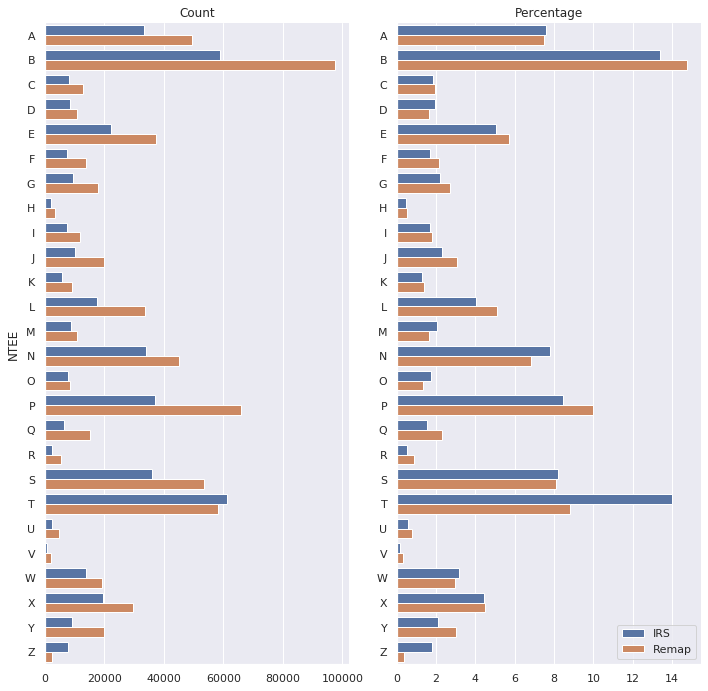

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# sns.set_context("notebook")

sns.set_color_codes("pastel")
g=sns.catplot(x="value", y="NTEE", hue='type1', col='type2', data=df_remapping_mg_2018_norm, kind='bar', sharex=False, sharey=False, height=10, aspect=0.5, legend=False, 
#               palette='pastel'
             )
g.set_ylabels("NTEE")
g.set_xlabels("")
g.set_titles("{col_name}")
plt.legend(loc='best')
g.savefig('../../output/remap_2018.pdf')

In [ ]:
df_remapping_mg_2018.to_excel('../../output/df_remapping_mg_2018.xlsx')

#### Seperate T/Not-T - Leave for future studies.

In [123]:
df_check_remapping_not_T=df_check_remapping[(df_check_remapping.NTEE1!='T')&(~df_check_remapping.Remap_NTEE.apply(str).str.contains('T'))]

In [124]:
# Recode null values.
df_check_remapping_not_T['NTEE1']=df_check_remapping_not_T.NTEE1.fillna('Z')
def assign_NA(cell):
    if len(cell)==0:
        return ['Z']
    else:
        return cell
df_check_remapping_not_T['Remap_NTEE']=df_check_remapping_not_T.Remap_NTEE.apply(assign_NA)

In [125]:
df_remapping_mg_2018_not_T=pd.DataFrame.from_dict(Counter(df_check_remapping_not_T.NTEE1.tolist()), orient='index').rename(columns={0:'IRS_NTEE'})
df_remapping_mg_2018_not_T=df_remapping_mg_2018_not_T.merge(pd.DataFrame.from_dict(Counter([item for sublist in df_check_remapping_not_T.Remap_NTEE for item in sublist]), orient='index').rename(columns={0:'Remap_NTEE'}),
                                                left_index=True, right_index=True, how='outer').sort_index()

In [126]:
df_remapping_mg_2018_not_T

IRS_NTEE  Remap_NTEE
A     32169       43902
B     55775       76388
C      7868       11997
D      8487       10481
E     21450       33462
F      7367       13478
G      9377       16512
H      1968        2979
I      7341       11501
J      9966       19705
K      5591        8804
L     17486       32079
M      8848       10682
N     33415       41986
O      7336        7912
P     35032       57633
Q      6247       13195
R      2305        5214
S     35157       49521
U      2458        4695
V       730        1965
W     13596       18460
X     18467       25561
Y      8947       15488
Z      7322        1232

In [127]:
df_remapping_mg_2018_not_T['IRS_NTEE_ptg']=df_remapping_mg_2018_not_T['IRS_NTEE']/df_remapping_mg_2018_not_T.IRS_NTEE.sum()
df_remapping_mg_2018_not_T['Remap_NTEE_ptg']=df_remapping_mg_2018_not_T['Remap_NTEE']/df_remapping_mg_2018_not_T.Remap_NTEE.sum()

In [128]:
df_remapping_mg_2018_not_T=df_remapping_mg_2018_not_T.reset_index().rename(columns={'index':'NTEE'})
df_remapping_mg_2018_not_T.NTEE.fillna('N/A', inplace=True)
df_remapping_mg_2018_not_T

NTEE  IRS_NTEE  Remap_NTEE  IRS_NTEE_ptg  Remap_NTEE_ptg
0     A     32169       43902      0.088206        0.082086
1     B     55775       76388      0.152932        0.142826
2     C      7868       11997      0.021574        0.022431
3     D      8487       10481      0.023271        0.019597
4     E     21450       33462      0.058815        0.062565
5     F      7367       13478      0.020200        0.025200
6     G      9377       16512      0.025711        0.030873
7     H      1968        2979      0.005396        0.005570
8     I      7341       11501      0.020129        0.021504
9     J      9966       19705      0.027326        0.036843
10    K      5591        8804      0.015330        0.016461
11    L     17486       32079      0.047946        0.059980
12    M      8848       10682      0.024261        0.019973
13    N     33415       41986      0.091622        0.078503
14    O      7336        7912      0.020115        0.014793
15    P     35032       57633      0.096056        0.107759
16    Q      6247       13195      0.017129        0.024671
17    R      2305        5214      0.006320        0.009749
18    S     35157       49521      0.096398        0.092592
19    U      2458        4695      0.006740        0.008778
20    V       730        1965      0.002002        0.003674
21    W     13596       18460      0.037279        0.034516
22    X     18467       25561      0.050635        0.047793
23    Y      8947       15488      0.024532        0.028959
24    Z      7322        1232      0.020077        0.002304

In [129]:
# Tidy data frame for viz.
df_remapping_mg_2018_norm_not_T=pd.DataFrame()
for index in df_remapping_mg_2018_not_T.index:
    ntee=df_remapping_mg_2018_not_T.at[index, 'NTEE']
    irs_count=df_remapping_mg_2018_not_T.at[index, 'IRS_NTEE']
    remap_count=df_remapping_mg_2018_not_T.at[index, 'Remap_NTEE']
    irs_ptg=df_remapping_mg_2018_not_T.at[index, 'IRS_NTEE_ptg']*100
    remap_ptg=df_remapping_mg_2018_not_T.at[index, 'Remap_NTEE_ptg']*100
    df_remapping_mg_2018_norm_not_T=df_remapping_mg_2018_norm_not_T.append(pd.DataFrame([[ntee, irs_count, 'IRS', 'Count']]))
    df_remapping_mg_2018_norm_not_T=df_remapping_mg_2018_norm_not_T.append(pd.DataFrame([[ntee, remap_count, 'Remap', 'Count']]))
    df_remapping_mg_2018_norm_not_T=df_remapping_mg_2018_norm_not_T.append(pd.DataFrame([[ntee, irs_ptg, 'IRS', 'Percentage']]))
    df_remapping_mg_2018_norm_not_T=df_remapping_mg_2018_norm_not_T.append(pd.DataFrame([[ntee, remap_ptg, 'Remap', 'Percentage']]))

In [130]:
df_remapping_mg_2018_norm_not_T.rename(columns={0:'NTEE', 1:'value', 2:'type1', 3:'type2'}, inplace=True)
df_remapping_mg_2018_norm_not_T

NTEE         value  type1       type2
0     A  32169.000000    IRS       Count
0     A  43902.000000  Remap       Count
0     A      8.820554    IRS  Percentage
0     A      8.208559  Remap  Percentage
0     B  55775.000000    IRS       Count
..  ...           ...    ...         ...
0     Y      2.895863  Remap  Percentage
0     Z   7322.000000    IRS       Count
0     Z   1232.000000  Remap       Count
0     Z      2.007650    IRS  Percentage
0     Z      0.230353  Remap  Percentage

[100 rows x 4 columns]

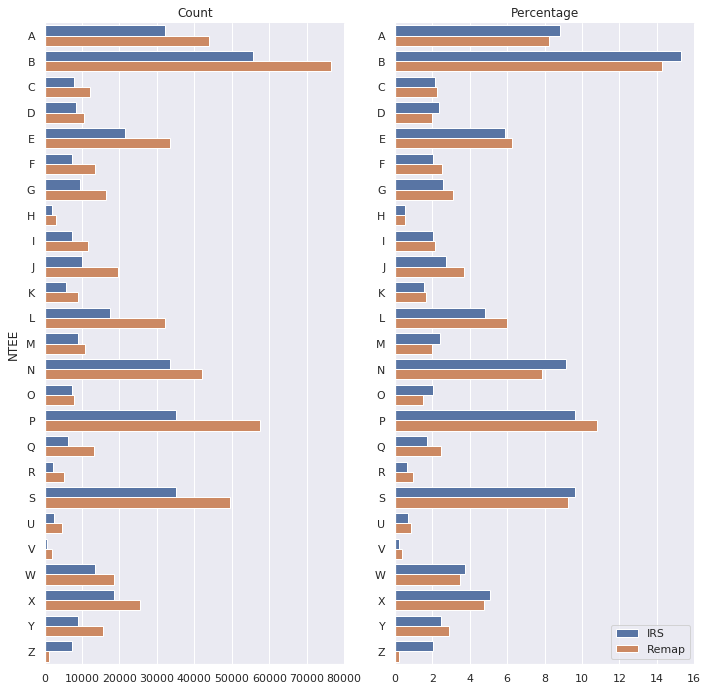

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# sns.set_context("notebook")

sns.set_color_codes("pastel")
g=sns.catplot(x="value", y="NTEE", hue='type1', col='type2', data=df_remapping_mg_2018_norm_not_T, kind='bar', sharex=False, sharey=False, height=10, aspect=0.5, legend=False, 
#               palette='pastel'
             )
g.set_ylabels("NTEE")
g.set_xlabels("")
g.set_titles("{col_name}")
plt.legend(loc='best')
g.savefig('../../output/remap_2018_not_T.pdf')

### DATA FOR TABLEAU VIZ

In [495]:
# df_ein_ntee=pd.DataFrame()
ein_ntee_list=[]
for ein, ntee_list in tqdm(df_check_remapping[['EIN', 'Remap_NTEE']].values.tolist()):
    ein_ntee_list+=[[ein, ntee] for ntee in ntee_list]

100%|██████████| 439160/439160 [00:00<00:00, 1114033.32it/s]


In [499]:
pd.DataFrame(ein_ntee_list).rename(columns={0:'EIN', 1:'Remap_NTEE'}).to_excel('../../output/df_ein_remap_ntee_2018.xlsx')

In [502]:
df_tableau=df_check_remapping[['EIN', 'TAXPAYER_NAME']].merge(df_bmf_18_20_dropdup[['EIN', 'ASSETS', 'INCOME', 'ADDRESS', 'CITY', 'STATE', 'ZIP5']], 
                                                              left_on='EIN', right_on='EIN', how='left'
                                                             )

In [503]:
df_tableau

EIN                                      TAXPAYER_NAME  \
0       752219984     FOREST CREEK ESTATE HOMEOWNERS ASSOCIATION INC   
1        66334270                        SUFFIELD HISTORICAL SOCIETY   
2       836036074  ZONA AND JACK LOOMIS PLATTE COUNTY SCHOOL DIST...   
3       953629655                   SANTA ANITA MUTUAL WATER COMPANY   
4       840405195                   UPPER PLATTE AND BEAVER CANAL CO   
...           ...                                                ...   
439155  472568680                                 MAXWELL FOUNDATION   
439156  236257083                               ANNENBERG FOUNDATION   
439157  263877688           LADERA FOUNDATION CO MARY MYERS KAUPPILA   
439158  465292259                 NOT UNLUCKY FOUNDATION CORPORATION   
439159  823754494                            PEGGY A BELL FOUNDATION   

              ASSETS        INCOME                       ADDRESS  \
0       9.030000e+03  5.829900e+04  3948 LEGACY DR STE 106 # 318   
1       1.245572e+06  7.480200e+04                    PO BOX 893   
2       9.203700e+04  1.720000e+02                    PO BOX 144   
3       5.689700e+04  6.282200e+04       3000 HOLLISTER RANCH RD   
4                NaN           NaN                           NaN   
...              ...           ...                           ...   
439155  2.800340e+05  5.051800e+04            6067 N SEQUOIA AVE   
439156  1.402323e+09  1.441673e+09          101 W ELM ST STE 510   
439157  1.782658e+06  4.353730e+05          160 COMMONWEALTH AVE   
439158  4.900000e+02  1.200000e+03                    5 RICES LN   
439159  1.000000e+00  1.000000e+00             195 DAPPLEGRAY RD   

                CITY STATE     ZIP5  
0              PLANO    TX  75023.0  
1           SUFFIELD    CT   6078.0  
2          WHEATLAND    WY  82201.0  
3            GAVIOTA    CA  93117.0  
4                NaN   NaN      NaN  
...              ...   ...      ...  
439155        FRESNO    CA  93711.0  
439156  CONSHOHOCKEN    PA  19428.0  
439157        BOSTON    MA   2116.0  
439158      WESTPORT    CT   6880.0  
439159   BELL CANYON    CA  91307.0  

[439160 rows x 8 columns]

In [504]:
df_tableau.to_excel('../../output/df_tableau.xlsx')

### Viz function selection

In [46]:
df_grid_search_history_broad_cat=pd.read_csv('../../output/grid_search_history_broad_cat.tsv', sep='\t').sort_values('val_acc', ascending=False)

In [48]:
df_grid_search_history_broad_cat.sample(3)

Unnamed: 0       acc   val_acc  val_acc_real      loss  val_loss  \
555          555  0.762768  0.734583           NaN  0.761871  0.842163   
4936        4936  0.173631  0.170655           NaN  8.650764  8.679786   
4133        4133  0.013601  0.014286           NaN  8.316889  8.213513   

      epochs  conv_num_filters  conv_kernel_size conv_act  out_act time_stamp  
555        6                32                 3     tanh  softmax        NaN  
4936      37               128                 3  sigmoid     tanh        NaN  
4133      34                64                 7  sigmoid     tanh        NaN

In [26]:
df_grid_search_history_broad_cat['conv_out_act']=df_grid_search_history_broad_cat.conv_act+'_'+df_grid_search_history_broad_cat.out_act

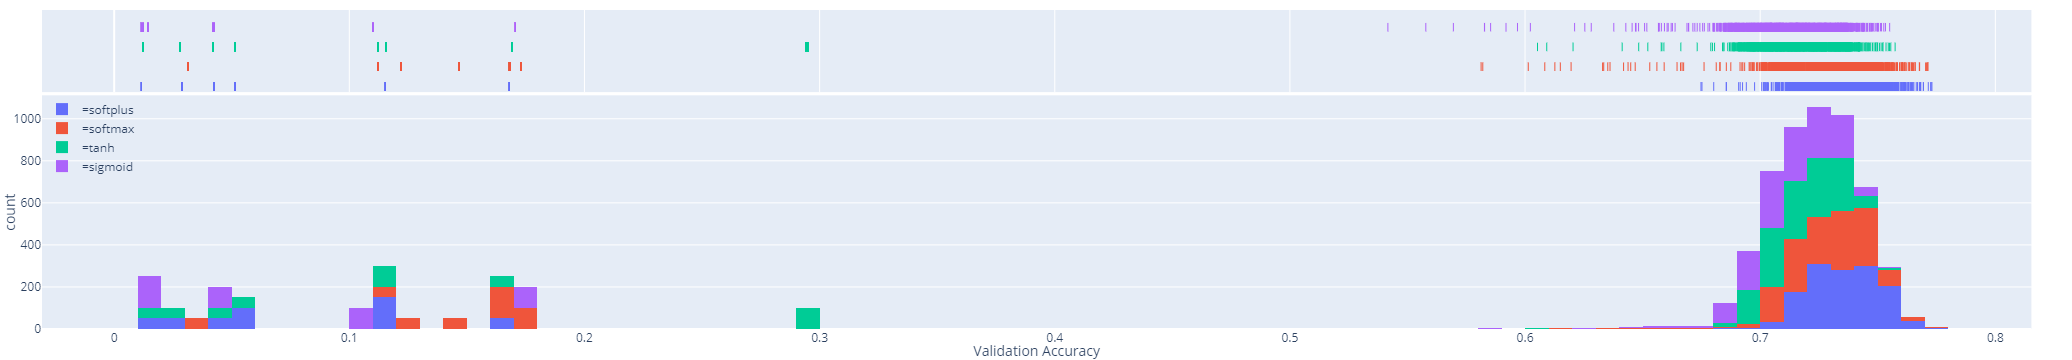

In [84]:
import plotly.express as px
fig = px.histogram(df_grid_search_history_broad_cat, x="val_acc", color="conv_act", marginal="rug", # can be `box`, `violin`
                         hover_data=df_grid_search_history_broad_cat.columns, nbins=150,
                   labels=dict(conv_act='', val_acc='Validation Accuracy', count='Count')
                  )
fig.update_layout(width=800, height=350)
fig.update_layout(
    legend=dict(x=0, y=0.6, orientation='v', bgcolor='rgba(0,0,0,0)'),
    margin={'t': 10, 'b': 10, 'r':0, 'l':20},
)
# fig.update_yaxes(title_text='Count')
fig.write_image('../../output/fig/grid_search_history_broad_cat.pdf')
fig.show()

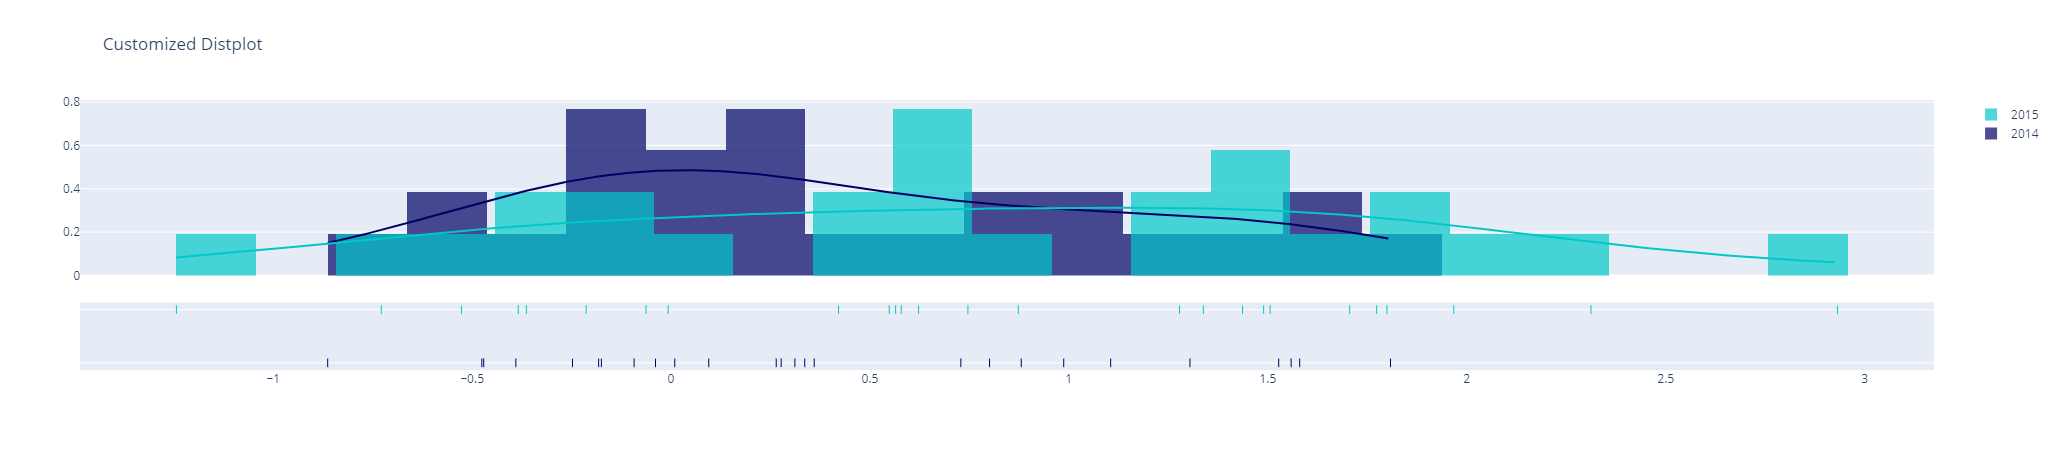

In [90]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(26)
x2 = np.random.randn(26) + .5

group_labels = ['2014', '2015']

rug_text_one = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                'u', 'v', 'w', 'x', 'y', 'z']

rug_text_two = ['aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj',
                'kk', 'll', 'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss', 'tt',
                'uu', 'vv', 'ww', 'xx', 'yy', 'zz']

rug_text = [rug_text_one, rug_text_two] # for hover in rug plot
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# Create distplot with custom bin_size
fig = ff.create_distplot(
    [x1, x2], group_labels, bin_size=.2,
    rug_text=rug_text, colors=colors)

fig.update_layout(title_text='Customized Distplot')
fig.show()

### Missing data analysis

In [2]:
train_file_path='../../dataset/UCF/train/'
file_list=os.listdir(train_file_path)
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, pd.read_pickle(train_file_path+file, compression='gzip')])

test_file_path='../../dataset/UCF/test/'
file_list=os.listdir(test_file_path)
df_test=pd.DataFrame()
for file in file_list:
    df_test=pd.concat([df_test, pd.read_pickle(test_file_path+file, compression='gzip')])
    
len(df_train), len(df_test)

(154424, 38607)

In [26]:
df_train.columns

Index(['DLN', 'EIN', 'FILING_TYPE', 'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt',
       'IRS990EZ_p3_PrmryExmptPrpsTxt', 'IRS990PF_p16b_RltnshpSttmntTxt',
       'IRS990PF_p9a_DscrptnTxt', 'IRS990ScheduleO_ExplntnTxt',
       'IRS990_p1_ActvtyOrMssnDsc', 'IRS990_p3_DscS', 'IRS990_p3_MssnDsc',
       'OBJECT_ID', 'RETURN_ID', 'RETURN_TYPE', 'SUB_DATE', 'TAXPAYER_NAME',
       'TAX_PERIOD', 'YEAR', '95_and_before', 'NTEE1', 'mission', 'prgrm_dsc',
       'mission_spellchk', 'prgrm_dsc_spellchk'],
      dtype='object')

In [27]:
len(df_train[df_train.mission_spellchk.isna()]), len(df_train[df_train.mission_spellchk.isna()]), len(df_train[df_train.mission_spellchk=='']), len(df_train[df_train.mission_spellchk==''])

(0, 0, 0, 0)

In [28]:
len(df_test[df_test.mission_spellchk.isna()]), len(df_test[df_test.mission_spellchk.isna()]), len(df_test[df_test.mission_spellchk=='']), len(df_test[df_test.mission_spellchk==''])

(0, 0, 0, 0)

In [24]:
len(df_train[df_train.prgrm_dsc_spellchk.isna()]), len(df_train[df_train.prgrm_dsc_spellchk.isna()]), len(df_train[df_train.prgrm_dsc_spellchk=='']), len(df_train[df_train.prgrm_dsc_spellchk==''])

(0, 0, 0, 0)

In [25]:
len(df_test[df_test.prgrm_dsc_spellchk.isna()]), len(df_test[df_test.prgrm_dsc_spellchk.isna()]), len(df_test[df_test.prgrm_dsc_spellchk=='']), len(df_test[df_test.prgrm_dsc_spellchk==''])

(0, 0, 0, 0)

In [ ]:
# Export to Excel. 
df_train.to_excel('../../output/df_train.xlsx')
df_test.to_excel('../../output/df_test.xlsx')